<a href="https://colab.research.google.com/github/Salahbendary/callAnalyzer/blob/main/CallAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
# Load the data
data = pd.read_csv("whatsappCall.csv", sep=",", encoding="ISO-8859-1")

# Inspect the first few rows of the data
data.head()


,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,192.168.137.140,34.193.38.112,TCP,69,"49923 > 5222 [PSH, ACK] Seq=1 Ack=1 Win=429 ..."
1,2,0.202052,34.193.38.112,192.168.137.140,TCP,66,5222 > 49923 [ACK] Seq=1 Ack=4 Win=140 Len=0...
2,3,0.274767,192.168.137.140,34.193.38.112,TCP,99,"49923 > 5222 [PSH, ACK] Seq=4 Ack=1 Win=429 ..."
3,4,0.509374,34.193.38.112,192.168.137.140,TCP,66,5222 > 49923 [ACK] Seq=1 Ack=37 Win=140 Len=...
4,5,0.510120,34.193.38.112,192.168.137.140,TCP,115,"5222 > 49923 [PSH, ACK] Seq=1 Ack=37 Win=140..."


In [ ]:
listOfTimeStamps = data['Time'].values
listOfProtocols = data['Protocol'].values
listOfInfos = data['Info'].values

TCPpackets = list(map(lambda p: 1 if "TCP" in p else 0, listOfProtocols))
UDPpackets = list(map(lambda p: 1 if "UDP" in p or "STUN" in p or "DNS" in p else 0, listOfProtocols))


In [ ]:
def detectWhenCallsEnded():
    timestamps = []
    unknownRequestInfoPackets = list(map(lambda i: 1 if "Unknown Request" in i else 0, listOfInfos))
    count = 0
    for i in range(len(unknownRequestInfoPackets)):
        if unknownRequestInfoPackets[i] == 1 and listOfProtocols[i] == "STUN":
            count += 1
            if count == 5:
                timestamps.append(listOfTimeStamps[i-4])
        else:
            count = 0
    return timestamps

def detectWhenCallsAnswered():
    timestamps = []
    successRequestInfoPackets = list(map(lambda i: 1 if "Allocate Success Response" in i else 0, listOfInfos))
    count = 0
    for i in range(len(successRequestInfoPackets)):
        if successRequestInfoPackets[i] == 1 and listOfProtocols[i] == "STUN":
            count += 1
            if count == 10 and listOfProtocols[i+1] == "UDP":
                timestamps.append(listOfTimeStamps[i-4])
        else:
            count = 0
    return timestamps

startOfCallTimeStamps = detectWhenCallsAnswered()
endOfCallTimeStamps = detectWhenCallsEnded()

for i in range(len(startOfCallTimeStamps)):
    print(f"A call started after {startOfCallTimeStamps[i]:.2f} seconds and lasted for {endOfCallTimeStamps[i] - startOfCallTimeStamps[i]:.2f} seconds")


A call started after 11.98 seconds and lasted for 40.46 seconds


In [ ]:
def countNumberOfPackets(packets, timestamps, cap):
    returnedPackets = []
    returnedtimestamps = []
    count = 0
    time = 0
    timePrev = 0
    for i in range(timestamps.size):
        time = float(timestamps[i])
        protocol = packets[i]
        if (time - timePrev) >= 0.1:
            if count > cap:
                count = cap
            returnedPackets.append(count)
            returnedtimestamps.append(time)
            count = 0
        if protocol:
            count += 1
        timePrev = time
    returnedPackets.append(count)
    returnedtimestamps.append(time)
    return returnedPackets, returnedtimestamps

TCPpackets, timestamps = countNumberOfPackets(TCPpackets, listOfTimeStamps, 200)
UDPpackets, timestamps = countNumberOfPackets(UDPpackets, listOfTimeStamps, max(TCPpackets) + 40)


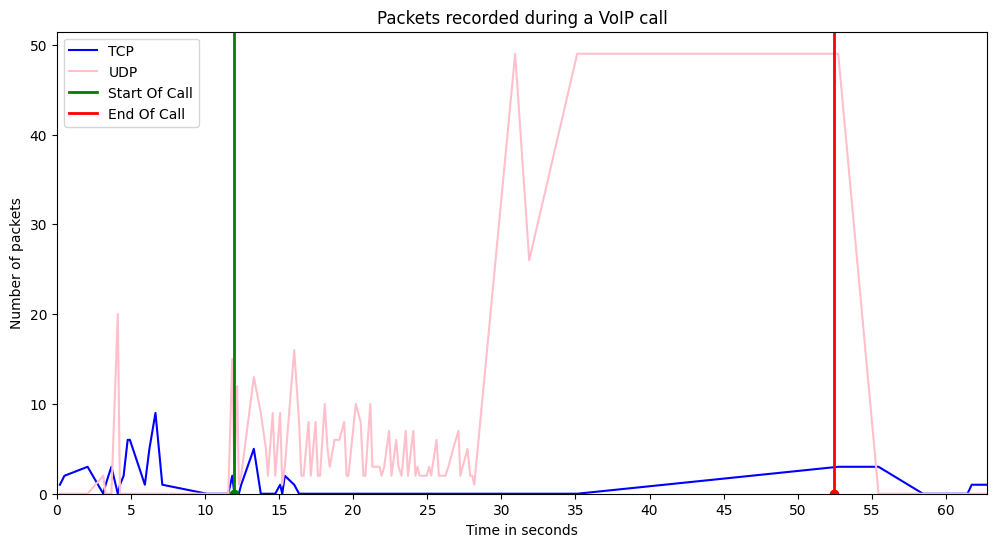

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(timestamps, TCPpackets, color="blue", label="TCP")
plt.plot(timestamps, UDPpackets, color="pink", label="UDP")

for t in startOfCallTimeStamps:
    plt.plot(t, 0, 'go')
    plt.axvline(t, 0, 100, label='Start Of Call', color="green", linewidth=2)

for t in endOfCallTimeStamps:
    plt.plot(t, 0, 'ro')
    plt.axvline(t, 0, 100, label='End Of Call', color="red", linewidth=2)

plt.ylabel('Number of packets')
plt.xlabel('Time in seconds')
plt.legend(loc="upper left")
plt.title('Packets recorded during a VoIP call')
plt.margins(0, 0.05, tight=True)
plt.xticks(np.arange(0, int(timestamps[-1]), 5))
plt.ylim(bottom=0)
plt.show()


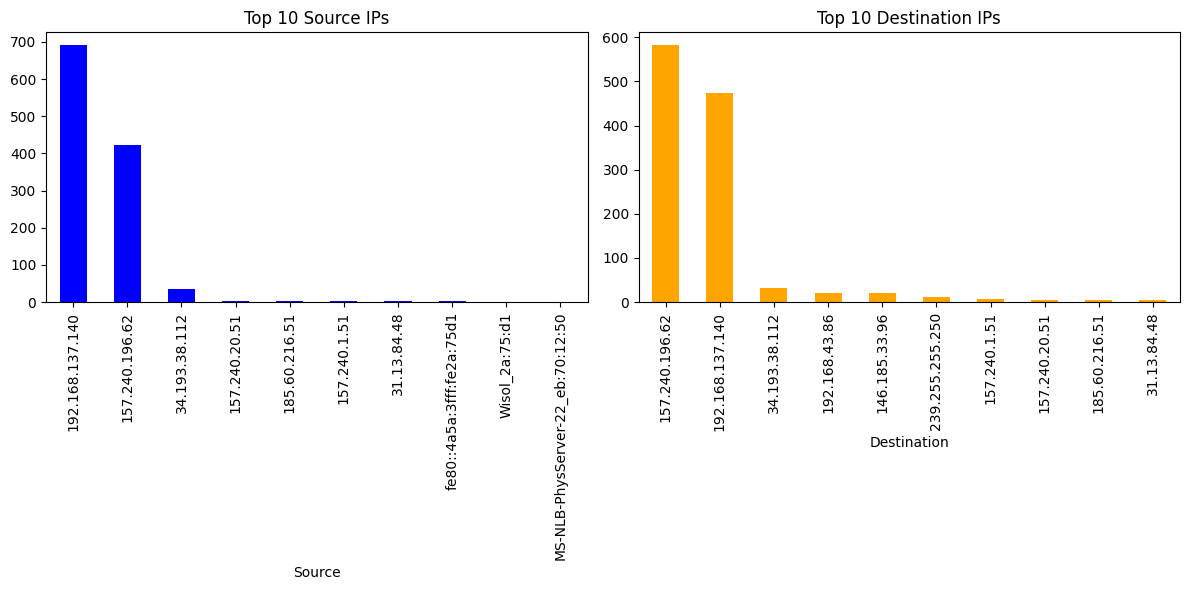

In [ ]:
top_sources = data['Source'].value_counts().head(10)
top_destinations = data['Destination'].value_counts().head(10)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
top_sources.plot(kind='bar', color='blue')
plt.title('Top 10 Source IPs')

plt.subplot(1, 2, 2)
top_destinations.plot(kind='bar', color='orange')
plt.title('Top 10 Destination IPs')

plt.tight_layout()
plt.show()


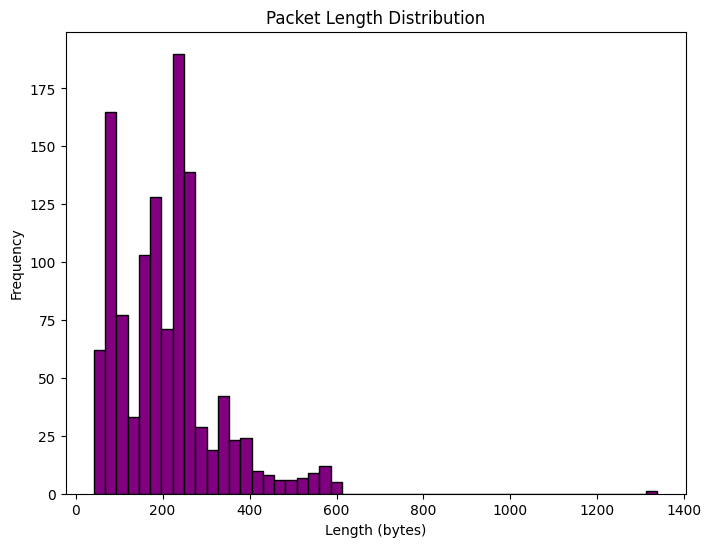

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(data['Length'], bins=50, color='purple', edgecolor='black')
plt.title('Packet Length Distribution')
plt.xlabel('Length (bytes)')
plt.ylabel('Frequency')
plt.show()


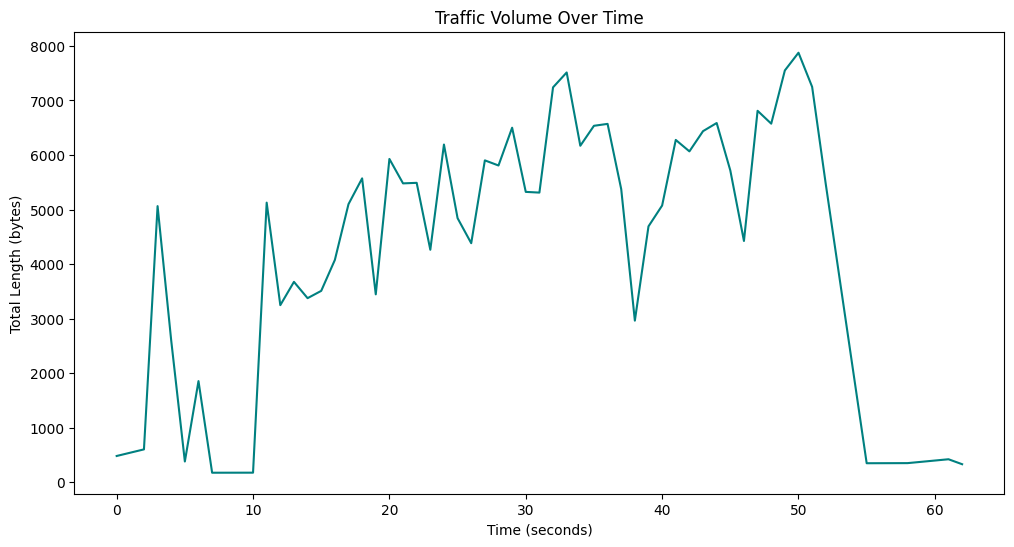

In [ ]:
data['Time'] = data['Time'].astype(float)
traffic_volume = data.groupby(data['Time'].astype(int))['Length'].sum()

plt.figure(figsize=(12, 6))
plt.plot(traffic_volume.index, traffic_volume.values, color='teal')
plt.title('Traffic Volume Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Total Length (bytes)')
plt.show()


In [ ]:
conversation_groups = data.groupby(['Source', 'Destination'])
conversation_stats = conversation_groups.agg({
    'Length': ['sum', 'count'],
    'Time': ['min', 'max']
})
conversation_stats.columns = ['TotalLength', 'PacketCount', 'StartTime', 'EndTime']
conversation_stats['Duration'] = conversation_stats['EndTime'] - conversation_stats['StartTime']

conversation_stats_sorted = conversation_stats.sort_values(by='TotalLength', ascending=False).head(10)
print(conversation_stats_sorted)


                                 TotalLength  PacketCount  StartTime  \
Source          Destination                                            
192.168.137.140 157.240.196.62        126584          582   3.678876   
157.240.196.62  192.168.137.140        94374          422   3.765013   
34.193.38.112   192.168.137.140         5101           35   0.202052   
192.168.137.140 34.193.38.112           4204           32   0.000000   
                239.255.255.250         2013           12   4.109589   
                192.168.43.86           1720           20  11.730511   
                146.185.33.96           1720           20  11.834845   
                157.240.1.51            1682            7   3.678876   
                157.240.20.51           1150            5   3.678876   
                185.60.216.51           1150            5   3.678876   

                                   EndTime   Duration  
Source          Destination                            
192.168.137.140 157.240

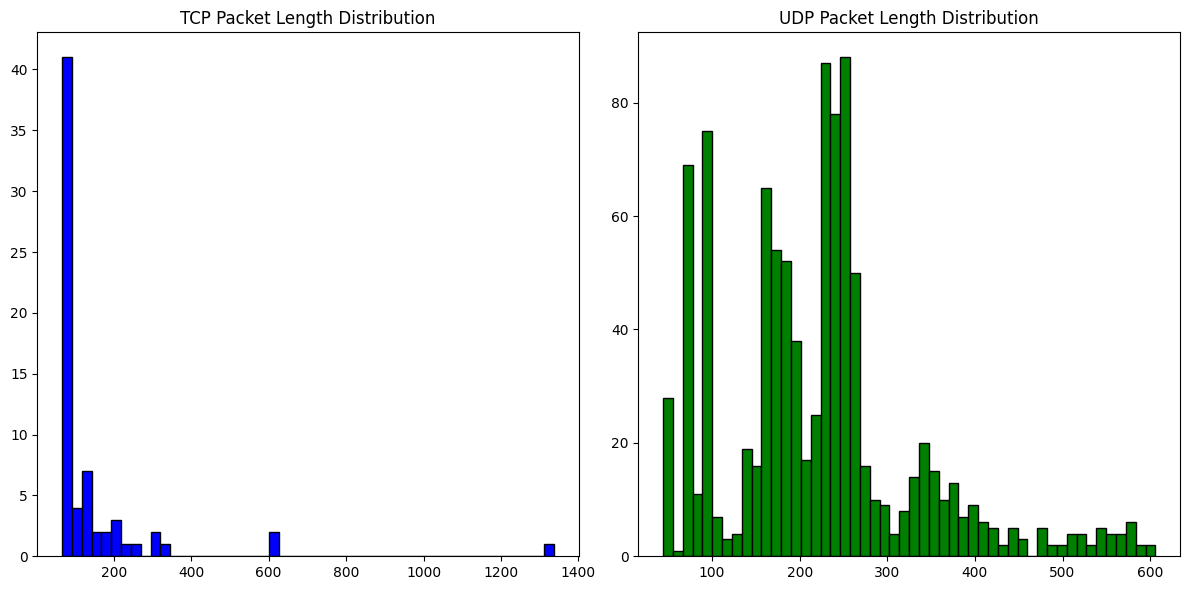

In [ ]:
tcp_data = data[data['Protocol'] == 'TCP']
udp_data = data[data['Protocol'] == 'UDP']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(tcp_data['Length'], bins=50, color='blue', edgecolor='black')
plt.title('TCP Packet Length Distribution')

plt.subplot(1, 2, 2)
plt.hist(udp_data['Length'], bins=50, color='green', edgecolor='black')
plt.title('UDP Packet Length Distribution')

plt.tight_layout()
plt.show()


In [ ]:
mean_length = data['Length'].mean()
std_length = data['Length'].std()
anomaly_threshold = mean_length + 3 * std_length

anomalies = data[data['Length'] > anomaly_threshold]
print(f"Detected {len(anomalies)} anomalies.")
print(anomalies)


Detected 20 anomalies.
     No.       Time           Source      Destination Protocol  Length  \
12    13   3.561583    34.193.38.112  192.168.137.140      TCP    1338   
37    38   4.265374  192.168.137.140    34.193.38.112      TCP     603   
44    45   4.776398  192.168.137.140    34.193.38.112      TCP     603   
273  274  20.345363  192.168.137.140   157.240.196.62      UDP     566   
281  282  20.818216  192.168.137.140   157.240.196.62      UDP     583   
287  288  20.979366  192.168.137.140   157.240.196.62      UDP     577   
290  291  21.155183  192.168.137.140   157.240.196.62      UDP     575   
300  301  21.617099  192.168.137.140   157.240.196.62      UDP     572   
305  306  21.932333  192.168.137.140   157.240.196.62      UDP     576   
308  309  22.091799  192.168.137.140   157.240.196.62      UDP     574   
312  313  22.253341  192.168.137.140   157.240.196.62      UDP     569   
319  320  22.739196  192.168.137.140   157.240.196.62      UDP     559   
322  323  22.90

In [ ]:
# Install the geoip2 package
!pip install geoip2

# Now, you can import geoip2
import geoip2.database


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 5.2 MB/s eta 0:00:00


In [ ]:
# Load GeoLite2 database
reader = geoip2.database.Reader('GeoLite2-City.mmdb')

def get_location(ip):
    try:
        response = reader.city(ip)
        return response.country.name, response.city.name
    except:
        return None, None

data['Country'], data['City'] = zip(*data['Source'].apply(get_location))

print(data[['Source', 'Country', 'City']].dropna().head(10))


            Source        Country       City
1    34.193.38.112  United States    Ashburn
3    34.193.38.112  United States    Ashburn
4    34.193.38.112  United States    Ashburn
9    34.193.38.112  United States    Ashburn
11   34.193.38.112  United States    Ashburn
12   34.193.38.112  United States    Ashburn
24  157.240.196.62         France  Marseille
25  157.240.196.62         France  Marseille
30    157.240.1.51          India    Kolkata
31    157.240.1.51          India    Kolkata


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv("whatsappCall.csv", sep=",", encoding="ISO-8859-1")

# Calculate packet length statistics
packet_length_mean = data['Length'].mean()
packet_length_median = data['Length'].median()
packet_length_std = data['Length'].std()
packet_length_var = data['Length'].var()

print(f"Mean Packet Length: {packet_length_mean}")
print(f"Median Packet Length: {packet_length_median}")
print(f"Standard Deviation of Packet Length: {packet_length_std}")
print(f"Variance of Packet Length: {packet_length_var}")


Mean Packet Length: 209.1514114627887
Median Packet Length: 203.0
Standard Deviation of Packet Length: 116.29218265524909
Variance of Packet Length: 13523.87174672182


In [ ]:
# Count the occurrence of each protocol
protocol_counts = data['Protocol'].value_counts()

print("Protocol Distribution:")
print(protocol_counts)


Protocol Distribution:
Protocol
UDP     985
STUN     92
TCP      67
SSDP     12
MDNS      6
TFTP      4
ARP       2
ICMP      1
Name: count, dtype: int64


In [ ]:
# Calculate protocol switching frequency
protocol_changes = data['Protocol'].ne(data['Protocol'].shift()).sum()

print(f"Protocol Switching Frequency: {protocol_changes}")


Protocol Switching Frequency: 130


In [ ]:
# Count the frequency of source and destination IPs
source_ip_counts = data['Source'].value_counts()
destination_ip_counts = data['Destination'].value_counts()

print("Source IP Frequency:")
print(source_ip_counts)

print("Destination IP Frequency:")
print(destination_ip_counts)


Source IP Frequency:
Source
192.168.137.140                     691
157.240.196.62                      422
34.193.38.112                        35
157.240.20.51                         4
185.60.216.51                         4
157.240.1.51                          4
31.13.84.48                           4
fe80::4a5a:3fff:fe2a:75d1             3
Wisol_2a:75:d1                        1
MS-NLB-PhysServer-22_eb:70:12:50      1
Name: count, dtype: int64
Destination IP Frequency:
Destination
157.240.196.62                      582
192.168.137.140                     473
34.193.38.112                        32
192.168.43.86                        20
146.185.33.96                        20
239.255.255.250                      12
157.240.1.51                          7
157.240.20.51                         5
185.60.216.51                         5
31.13.84.48                           5
224.0.0.251                           3
ff02::fb                              3
MS-NLB-PhysServer-22_eb:70:1